<center><h1>STATS 503: Statistical Learning II: Modern Multivariate Analysis</h1>
    <h2> Data Challenge</h2></center><br>
   <b>Submitted by:</b> Akshat Porwal<br>
    <b>UNIQNAME:</b> akshatp
    <hr>

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Reading the data

In [ ]:
df_final = pd.DataFrame()

for i in range(1,21635):
    # Reading the individual text file
    path = "x_all/" + str(i) + ".txt"
    df = pd.read_csv(path)
    df = pd.pivot_table(df, index = 'Hour', columns = 'Variable' ,values = 'Value').reset_index()
    
    # Calculating mean
    df_mean = pd.DataFrame(df.mean())
    df_mean = df_mean.rename(columns = {0:'Value'})
    df_mean = pd.pivot_table(df_mean, columns = 'Variable' , values = 'Value').reset_index()
    df_mean = df_mean.drop(columns = ['index', 'Hour'])
    df_mean.columns = df_mean.columns + '_mean'
    
    # Calculating Standard Deviation
    df_std = pd.DataFrame(df.mean())
    df_std = df_std.rename(columns = {0:'Value'})
    df_std = pd.pivot_table(df_std, columns = 'Variable' , values = 'Value').reset_index()
    df_std = df_std.drop(columns = ['index', 'Hour'])
    df_std.columns = df_std.columns + '_std'
    
    # Calculating Range
    df_range = pd.DataFrame(df.max() - df.min())
    df_range = df_range.rename(columns = {0:'Value'})
    df_range = pd.pivot_table(df_range, columns = 'Variable' , values = 'Value').reset_index()
    df_range = df_range.drop(columns = ['index', 'Hour'])
    df_range.columns = df_range.columns + '_range'
    
    # Combining the dataframes
    lst_comb = [df_mean, df_std,df_range]
    df_combine = pd.concat(lst_comb, axis = 1)
    df_combine = df_combine.drop(columns = ['ID_std', 'ID_range'])
    df_combine = df_combine.rename(columns = {'ID_mean': 'ID'})
    
    # Merging all files
    df_final = df_final.append(df_combine)

In [ ]:
df_final = df_final.set_index('ID').reset_index()
df_final.head(6)

In [ ]:
df_final.to_csv('combined_data_summarystats.csv')

In [2]:
df = pd.read_csv('combined_data_summarystats.csv')
df.head()

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,Alkalinephos_std,Bilirubin_total_std,EtCO2_std,AST_range,Alkalinephos_range,Bilirubin_total_range,EtCO2_range,Bilirubin_direct_mean,Bilirubin_direct_std,Bilirubin_direct_range
0,1,50.73,15.000000,0.500000,61.580000,1,68.331250,40.900000,13.200000,77.228667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,66.67,12.035000,0.700000,58.804000,1,89.924500,27.417500,9.130000,75.333000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,79.74,10.190000,0.566667,55.344848,0,83.729600,30.742500,10.563750,75.293269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,35.18,NaN,0.750000,78.196944,1,107.003939,42.500000,14.200000,104.096286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,60.74,12.291667,0.703333,75.085207,1,74.814603,42.238333,14.018333,99.515625,...,58.0,1.3,30.762093,0.0,0.0,0.0,20.84,NaN,NaN,NaN


In [3]:
# Removing Null Columns with greater than 90%
for col in df.columns:
    if df[col].isna().sum()/len(df) > 0.9:
        df = df.drop(columns = [col])

In [4]:
df

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,TroponinI_range,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range
0,1,50.73,15.000000,0.500000,61.580000,1,68.331250,40.900000,13.200000,77.228667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,66.67,12.035000,0.700000,58.804000,1,89.924500,27.417500,9.130000,75.333000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,79.74,10.190000,0.566667,55.344848,0,83.729600,30.742500,10.563750,75.293269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,35.18,NaN,0.750000,78.196944,1,107.003939,42.500000,14.200000,104.096286,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,60.74,12.291667,0.703333,75.085207,1,74.814603,42.238333,14.018333,99.515625,...,0.0,36.0,58.0,1.3,36.0,58.0,1.3,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21629,21630,65.41,38.806667,3.893333,62.823750,1,94.114750,28.277500,10.100000,84.086000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21630,21631,61.00,11.320000,0.800000,65.402581,1,78.869091,37.696667,12.971250,84.931212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21631,21632,58.61,80.045000,1.800000,66.054167,1,96.119231,33.017500,10.925000,77.470769,...,NaN,519.0,56.0,0.3,519.0,56.0,0.3,0.0,0.0,0.0
21632,21633,58.58,94.620000,1.200000,NaN,1,91.045294,28.710000,10.145000,72.798125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Segregating Actual Training Data

In [5]:
train_outcome = pd.read_csv(r'train_outcome.csv')

In [6]:
training_data = pd.merge(df, train_outcome, how = 'inner', on = 'ID')
training_data

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range,Outcome
0,2,66.67,12.035000,0.700000,58.804000,1,89.924500,27.417500,9.130000,75.333000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3,79.74,10.190000,0.566667,55.344848,0,83.729600,30.742500,10.563750,75.293269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4,35.18,NaN,0.750000,78.196944,1,107.003939,42.500000,14.200000,104.096286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,5,60.74,12.291667,0.703333,75.085207,1,74.814603,42.238333,14.018333,99.515625,...,36.00,58.00,1.3,36.00,58.00,1.3,0.00,0.0,0.0,1
4,6,77.32,26.415000,0.465000,NaN,0,61.970244,29.576667,9.690000,80.990000,...,24.95,70.18,0.3,24.95,70.18,0.3,2.08,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15139,21628,61.44,14.000000,0.700000,50.691667,1,103.457778,32.305000,11.900000,71.611667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15140,21629,63.82,23.820000,1.095000,54.598750,0,90.500851,27.373333,9.223333,83.556739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15141,21630,65.41,38.806667,3.893333,62.823750,1,94.114750,28.277500,10.100000,84.086000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15142,21632,58.61,80.045000,1.800000,66.054167,1,96.119231,33.017500,10.925000,77.470769,...,519.00,56.00,0.3,519.00,56.00,0.3,0.00,0.0,0.0,1


## Splitting Actual Training Data into Sub-Training & Sub-Testing

In [17]:
X_strain, X_stest, y_strain, y_stest = train_test_split(training_data.drop(columns = ['Outcome']), 
                                                    training_data['Outcome'] , test_size=0.3,
                                                        stratify = training_data['Outcome'])

In [18]:
X_strain

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,TroponinI_range,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range
12327,17602,47.57,NaN,NaN,62.815000,0,59.330000,NaN,NaN,79.000000,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,2830,53.78,13.000,0.700000,51.696250,1,86.657500,27.0900,10.805000,68.338421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11706,16694,81.21,NaN,NaN,45.299667,1,62.414138,NaN,NaN,61.486296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7185,10257,52.87,10.885,0.500000,45.051111,0,70.306316,31.3400,10.190000,57.603333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4175,6003,66.80,17.555,0.770000,53.390986,1,65.082603,33.0575,10.787500,77.608667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,3119,62.97,26.710,2.040000,59.421892,1,76.729231,34.3975,12.016667,69.108750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11836,16879,85.12,8.000,0.500000,NaN,0,80.877500,28.7000,9.000000,47.505000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7975,11379,69.08,32.430,1.395000,62.261250,0,107.440789,30.4730,9.570000,87.089024,...,1.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11752,16763,59.87,19.000,2.100000,NaN,1,78.822500,33.3000,NaN,79.555789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Imputing Missing Values with Median

### Sub Training Data

In [20]:
# Checking Percentage of Null Values in Sub Training Data
X_strain.isna().sum()/len(X_strain)*100

ID                        0.000000
Age_mean                  0.000000
BUN_mean                  8.198113
Creatinine_mean           8.641509
DBP_mean                 19.056604
                           ...    
Alkalinephos_std         69.056604
Bilirubin_total_std      69.084906
AST_range                68.509434
Alkalinephos_range       69.056604
Bilirubin_total_range    69.084906
Length: 106, dtype: float64

In [21]:
X_strain_median = X_strain.fillna(X_strain.median())

In [22]:
X_strain_median

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,TroponinI_range,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range
12327,17602,47.57,16.555,0.908750,62.815000,0,59.330000,31.3050,10.505000,79.000000,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
1961,2830,53.78,13.000,0.700000,51.696250,1,86.657500,27.0900,10.805000,68.338421,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
11706,16694,81.21,16.555,0.908750,45.299667,1,62.414138,31.3050,10.505000,61.486296,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
7185,10257,52.87,10.885,0.500000,45.051111,0,70.306316,31.3400,10.190000,57.603333,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
4175,6003,66.80,17.555,0.770000,53.390986,1,65.082603,33.0575,10.787500,77.608667,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,3119,62.97,26.710,2.040000,59.421892,1,76.729231,34.3975,12.016667,69.108750,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
11836,16879,85.12,8.000,0.500000,62.727759,0,80.877500,28.7000,9.000000,47.505000,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
7975,11379,69.08,32.430,1.395000,62.261250,0,107.440789,30.4730,9.570000,87.089024,...,1.47,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0
11752,16763,59.87,19.000,2.100000,62.727759,1,78.822500,33.3000,10.505000,79.555789,...,0.00,35.0,72.975,0.76,35.0,72.975,0.76,0.0,0.0,0.0


### Sub Testing Data

In [23]:
# Checking Percentage of Null Values in Sub Training Data
X_stest.isna().sum()/len(X_stest)*100

ID                        0.000000
Age_mean                  0.000000
BUN_mean                  8.406690
Creatinine_mean           9.066901
DBP_mean                 19.740317
                           ...    
Alkalinephos_std         68.419894
Bilirubin_total_std      68.661972
AST_range                68.177817
Alkalinephos_range       68.419894
Bilirubin_total_range    68.661972
Length: 106, dtype: float64

In [24]:
X_stest_median = X_stest.fillna(X_stest.median())

In [25]:
X_stest_median

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,TroponinI_range,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range
4452,6383,76.19,41.565000,1.697500,67.644490,1,78.451224,33.006667,10.86000,90.935745,...,0.05,35.000,71.300,0.750,35.000,71.300,0.750,0.00,0.00,0.00
6304,8994,48.53,19.000000,1.000000,62.933636,1,94.621786,39.800000,14.20000,103.231111,...,0.00,35.000,71.300,0.750,35.000,71.300,0.750,0.00,0.00,0.00
8303,11856,81.30,35.346667,2.380000,62.933636,0,74.047353,29.396667,9.95000,58.186471,...,0.00,35.000,71.300,0.750,35.000,71.300,0.750,0.00,0.00,0.00
3572,5158,48.54,10.000000,0.470000,63.931786,0,100.479375,29.300000,8.30000,90.364815,...,0.00,35.000,71.300,0.750,35.000,71.300,0.750,0.00,0.00,0.00
14733,21021,30.90,8.000000,0.600000,57.733000,0,81.735476,28.600000,10.49125,71.696774,...,0.00,35.000,71.300,0.750,35.000,71.300,0.750,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13631,19460,76.48,8.676667,0.630000,75.384839,0,89.414194,29.690000,10.09500,112.056296,...,0.01,133.350,297.590,0.750,133.350,297.590,0.750,27.74,72.08,0.30
3645,5265,66.54,7.000000,0.600000,62.933636,1,86.474643,29.112500,9.40000,62.623846,...,0.00,35.000,71.300,0.750,35.000,71.300,0.750,0.00,0.00,0.00
11568,16496,69.39,20.986667,1.623333,60.656383,1,95.825333,33.005000,11.35000,74.310435,...,0.00,15.375,62.035,2.350,15.375,62.035,2.350,2.97,4.23,0.10
4090,5885,60.41,50.100000,2.075000,72.472632,1,64.293043,36.300000,10.49125,98.953158,...,0.00,19.175,79.620,0.445,19.175,79.620,0.445,6.79,2.84,0.11


## Applying the Models

### Random Forest

In [69]:
clf = RandomForestClassifier(random_state = 0, max_features =  X_strain_median.shape[1], class_weight='balanced')
clf.fit(X_strain_median, y_strain)
accuracy = clf.score(X_stest_median, y_stest)
test_error_bagging = 1 - accuracy
test_error_bagging

0.1109154929577465

In [70]:
y_pred = clf.predict(X_stest_median)

In [71]:
print(classification_report(y_stest, y_pred))
print('Area under curve score for Random Forests is: ', roc_auc_score(y_stest, clf.predict_proba(X_stest_median)[:, 1]))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3924
           1       0.76      0.27      0.40       620

    accuracy                           0.89      4544
   macro avg       0.83      0.63      0.67      4544
weighted avg       0.88      0.89      0.87      4544

Area under curve score for Random Forests is:  0.8435424270823058


### ADA Boost

In [72]:
adaboost = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.2)
adaboost.fit(X_strain_median, y_strain)

AdaBoostClassifier(learning_rate=0.2, n_estimators=500)

In [73]:
pred = adaboost.predict(X_stest_median)
acc = np.mean(pred == y_stest)
1- acc

0.11421654929577463

In [74]:
print(classification_report(y_stest, pred))
print('AUC score for Random Forests is: ', roc_auc_score(y_stest, adaboost.predict_proba(X_stest_median)[:, 1]))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3924
           1       0.66      0.34      0.45       620

    accuracy                           0.89      4544
   macro avg       0.78      0.65      0.69      4544
weighted avg       0.87      0.89      0.87      4544

AUC score for Random Forests is:  0.8484627273026207


In [75]:
# Prediction Probabilities
adaboost.predict_proba(X_stest_median)

array([[0.50846618, 0.49153382],
       [0.50195114, 0.49804886],
       [0.5048492 , 0.4951508 ],
       ...,
       [0.50711827, 0.49288173],
       [0.50938758, 0.49061242],
       [0.50986117, 0.49013883]])

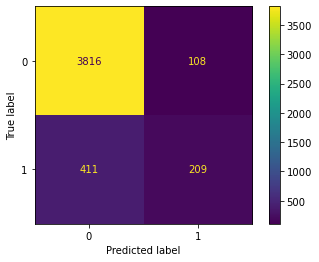

In [76]:
# Confusion Matrix for ADA Boost
cm_test_log = confusion_matrix(y_stest, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_test_log, display_labels = adaboost.classes_)
cm_display.plot();

### XGBoost

In [77]:
model = XGBClassifier(learning_rate = 0.2)
model.fit(X_strain_median, y_strain)

y_pred = model.predict(X_stest_median)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_stest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_stest, predictions))
print('AUC score for XGBoost is: ', roc_auc_score(y_stest, model.predict_proba(X_stest_median)[:,1]))

Accuracy: 89.74%
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3924
           1       0.73      0.40      0.51       620

    accuracy                           0.90      4544
   macro avg       0.82      0.69      0.73      4544
weighted avg       0.89      0.90      0.88      4544

AUC score for XGBoost is:  0.8677172733550359


### Histogram Gradient Boosting

In [26]:
model = HistGradientBoostingClassifier(max_bins=255, max_iter=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_strain_median, y_strain, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
model.fit(X_strain_median, y_strain)
predictions = model.predict(X_stest_median)
acc = np.mean(predictions == y_stest)
print("Error Rate", 1- acc)
print(classification_report(y_stest, predictions))
print('AUC score for Histogram Gradient Boosting is: ', roc_auc_score(y_stest, model.predict_proba(X_stest_median)[:,1]))

Accuracy: 0.904 (0.005)
Error Rate 0.10013204225352113
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3924
           1       0.74      0.41      0.53       620

    accuracy                           0.90      4544
   macro avg       0.83      0.69      0.74      4544
weighted avg       0.89      0.90      0.89      4544

AUC score for Histogram Gradient Boosting is:  0.8715966262207753


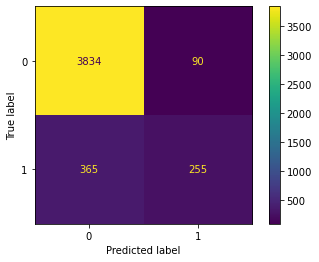

In [27]:
cm_test_log = confusion_matrix(y_stest, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_test_log, display_labels = model.classes_)
cm_display.plot();

## Performing Final Analysis

### Reading Test Data

In [28]:
test_nolabel = pd.read_csv(r'test_nolabel.csv')

In [29]:
testing_data = pd.merge(df, test_nolabel, how = 'inner', on = 'ID')
testing_data

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range,Outcome,Score
0,1,50.73,15.000000,0.500000,61.580000,1,68.331250,40.900000,13.200000,77.228667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,73.55,17.000000,1.060000,65.152857,1,88.122308,40.700000,13.500000,86.524375,...,NaN,0.800000,22.000000,NaN,0.800000,0.00,NaN,0.00,NaN,NaN
2,9,52.71,12.000000,0.820000,63.537222,1,86.304444,37.000000,12.000000,83.617895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,66.65,11.663333,0.513333,75.489318,1,102.503721,32.823333,10.736667,94.900698,...,46.005000,1.595000,29.485000,46.005000,1.595000,3.05,1.79,0.65,NaN,NaN
4,11,84.08,81.796667,4.665000,NaN,0,93.352564,37.705000,11.520000,80.067073,...,NaN,NaN,33.000000,NaN,NaN,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6485,21617,44.84,8.000000,0.740000,64.179412,0,61.203750,34.400000,11.000000,82.673571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6486,21623,61.04,12.769000,0.540000,58.616000,0,99.837073,27.748750,9.793750,71.222564,...,272.418571,0.956667,1078.175714,272.418571,0.956667,1688.50,129.81,0.49,NaN,NaN
6487,21627,44.47,NaN,NaN,89.780968,1,128.481034,NaN,NaN,100.761613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6488,21631,61.00,11.320000,0.800000,65.402581,1,78.869091,37.696667,12.971250,84.931212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
training_data

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range,Outcome
0,2,66.67,12.035000,0.700000,58.804000,1,89.924500,27.417500,9.130000,75.333000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3,79.74,10.190000,0.566667,55.344848,0,83.729600,30.742500,10.563750,75.293269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4,35.18,NaN,0.750000,78.196944,1,107.003939,42.500000,14.200000,104.096286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,5,60.74,12.291667,0.703333,75.085207,1,74.814603,42.238333,14.018333,99.515625,...,36.00,58.00,1.3,36.00,58.00,1.3,0.00,0.0,0.0,1
4,6,77.32,26.415000,0.465000,NaN,0,61.970244,29.576667,9.690000,80.990000,...,24.95,70.18,0.3,24.95,70.18,0.3,2.08,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15139,21628,61.44,14.000000,0.700000,50.691667,1,103.457778,32.305000,11.900000,71.611667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15140,21629,63.82,23.820000,1.095000,54.598750,0,90.500851,27.373333,9.223333,83.556739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15141,21630,65.41,38.806667,3.893333,62.823750,1,94.114750,28.277500,10.100000,84.086000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15142,21632,58.61,80.045000,1.800000,66.054167,1,96.119231,33.017500,10.925000,77.470769,...,519.00,56.00,0.3,519.00,56.00,0.3,0.00,0.0,0.0,1


In [31]:
# Segregating X and y values
X_train = training_data.drop(columns = ['Outcome'])
y_train = training_data['Outcome']
X_test = testing_data

### Replacing NaN values with median

In [32]:
X_train_median = X_train.fillna(X_train.median())
X_test_median = X_test.fillna(X_test.median())

In [33]:
X_train_median

,ID,Age_mean,BUN_mean,Creatinine_mean,DBP_mean,Gender_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,...,TroponinI_range,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,AST_std,Alkalinephos_std,Bilirubin_total_std,AST_range,Alkalinephos_range,Bilirubin_total_range
0,2,66.67,12.035000,0.700000,58.804000,1,89.924500,27.417500,9.130000,75.333000,...,0.0,35.00,72.00,0.755,35.00,72.00,0.755,0.00,0.0,0.0
1,3,79.74,10.190000,0.566667,55.344848,0,83.729600,30.742500,10.563750,75.293269,...,0.0,35.00,72.00,0.755,35.00,72.00,0.755,0.00,0.0,0.0
2,4,35.18,16.555000,0.750000,78.196944,1,107.003939,42.500000,14.200000,104.096286,...,0.0,35.00,72.00,0.755,35.00,72.00,0.755,0.00,0.0,0.0
3,5,60.74,12.291667,0.703333,75.085207,1,74.814603,42.238333,14.018333,99.515625,...,0.0,36.00,58.00,1.300,36.00,58.00,1.300,0.00,0.0,0.0
4,6,77.32,26.415000,0.465000,62.804516,0,61.970244,29.576667,9.690000,80.990000,...,0.0,24.95,70.18,0.300,24.95,70.18,0.300,2.08,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15139,21628,61.44,14.000000,0.700000,50.691667,1,103.457778,32.305000,11.900000,71.611667,...,0.0,35.00,72.00,0.755,35.00,72.00,0.755,0.00,0.0,0.0
15140,21629,63.82,23.820000,1.095000,54.598750,0,90.500851,27.373333,9.223333,83.556739,...,0.0,35.00,72.00,0.755,35.00,72.00,0.755,0.00,0.0,0.0
15141,21630,65.41,38.806667,3.893333,62.823750,1,94.114750,28.277500,10.100000,84.086000,...,0.0,35.00,72.00,0.755,35.00,72.00,0.755,0.00,0.0,0.0
15142,21632,58.61,80.045000,1.800000,66.054167,1,96.119231,33.017500,10.925000,77.470769,...,0.0,519.00,56.00,0.300,519.00,56.00,0.300,0.00,0.0,0.0


In [34]:
X_test_median = X_test_median.drop(columns = ['Outcome','Score'])

### Applying Histogram Gradient Boosting

In [35]:
model = HistGradientBoostingClassifier(max_bins=255, max_iter=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_median, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
model.fit(X_train_median, y_train)
predictions = model.predict(X_test_median)

In [36]:
np.unique(predictions, return_counts=True)

(array([0, 1], dtype=int64), array([5974,  516], dtype=int64))

In [37]:
pred_outcome = pd.DataFrame(predictions)
pred_outcome = pred_outcome.rename(columns = {0: 'Outcome'})

In [65]:
score = pd.DataFrame(model.predict_proba(X_test_median))
score = pd.DataFrame(score.max(axis = 1))
score = score.rename(columns = {0:'Score'})

In [67]:
test_nolabel.Outcome = pred_outcome.Outcome
test_nolabel.Score = score.Score

In [68]:
test_nolabel.to_csv('akshatp_test_label.csv')